In [91]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/'+dir_out
flist = glob.glob(dir_out+"*xz_pstrain*")
flist.sort()
print([f.split('/')[-1] for f in flist])


Params for this run:
	Mc = 0.2
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 512x724x256
	L = 150.0x200.0x75.0
[]


In [90]:
# correlation coeff
def get_pstrain(hf,key):
    key = key.split('p')[1]
    ps = np.array(hf['p'])*np.array(hf[key])
    return ps

def get_corrcoef(flist,key1,key2):
    mat = np.zeros([len(flist),1])
    for i,f in enumerate(flist):
        hf = h5py.File(f, 'r')
        if key1[:2]=='ps': dat1 = get_pstrain(hf,key1)
        else: dat1=hf[key1]
        if key2[:2]=='ps': dat2 = get_pstrain(hf,key2)
        else: dat2=hf[key2]
        dat1 = np.array(dat1).flatten()
        dat2 = np.array(dat2).flatten()
        Cij = np.corrcoef(dat1,dat2)
        mat[i,0] = Cij[0][1]
        hf.close()
    return mat

def get_stats(flist,key):
    mat = np.zeros([len(flist),1])
    for i,f in enumerate(flist):
        hf = h5py.File(f, 'r')
        dat1 = np.array(hf[key])
        #mat[i,0] = np.var(dat1.flatten())
        mat[i,0]= np.sqrt(np.mean((dat1.flatten())**2)) #rms
        #mat[i,0] = skew(dat1.flatten())
        #mat[i,0] = kurtosis(dat1.flatten(),fisher=False)
        #mat[i,0] = np.amin(dat1.flatten())
        hf.close()
    return mat

def get_rms(flist,qname):
    mat = get_stats(flist[:],qname)
    qrms = np.mean(mat[:,0]); qstd = np.std(mat[:,0])
    return qrms,qstd


mat = get_corrcoef(flist,'ps11','ps22')
print(np.mean(mat[:,0]),np.std(mat[:,0]))




(nan, nan)


Cutoff kc = 11.46


Text(0.5,0,'$k$')

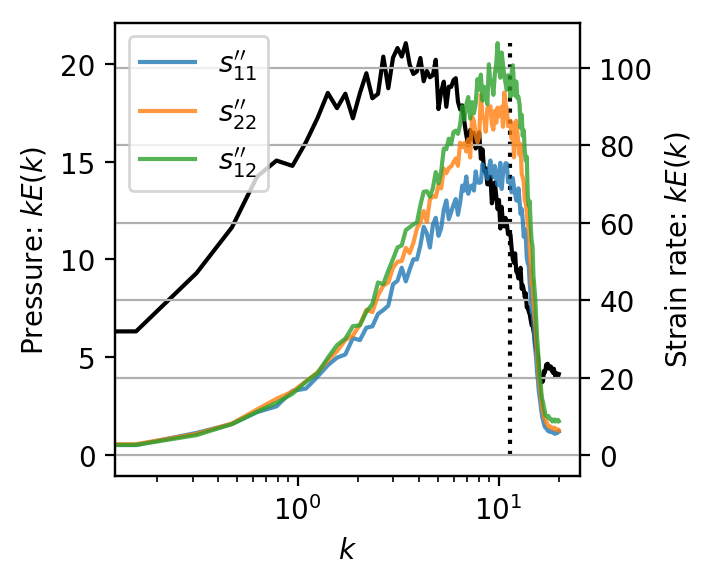

In [26]:
hf = h5py.File(flist[-1], 'r')
suffix=''
dat1 = np.array(hf['p'+suffix])
dat2 = np.array(hf['s12'+suffix])
dat3 = np.array(hf['s11'+suffix])
dat4 = np.array(hf['s22'+suffix])

fftdir=1
if fftdir==0: avgdir=1;N=Nx;L=Lx
if fftdir==1: avgdir=0;N=Nz;L=Lz
d1 = np.fft.fft(dat1,axis=fftdir)
d2 = np.fft.fft(dat2,axis=fftdir)
d3 = np.fft.fft(dat3,axis=fftdir)
d4 = np.fft.fft(dat4,axis=fftdir)
d1 = np.mean(abs(d1),axis=avgdir)[:N/2]
d2 = np.mean(abs(d2),axis=avgdir)[:N/2]
d3 = np.mean(abs(d3),axis=avgdir)[:N/2]
d4 = np.mean(abs(d4),axis=avgdir)[:N/2]
k = [2*np.pi/L*j for j in range(int(N/2))]

plt.figure(figsize=(3,3),dpi=200)
plt.semilogx(k,d1*k,'k',label="$p'$")
plt.xlabel(r'$k$')
plt.ylabel(r'Pressure: $kE(k)$')

kc= 11.46
print('Cutoff kc = {}'.format(kc))
plt.plot([kc,kc],[0,np.amax(d1*k)],'k:')

plt.twinx()
a=0.8
plt.semilogx(k,d2*k,alpha=a,label="$s_{11}''$")
plt.semilogx(k,d3*k,alpha=a,label="$s_{22}''$")
plt.semilogx(k,d4*k,alpha=a,label="$s_{12}''$")
plt.ylabel(r'Strain rate: $kE(k)$')
plt.legend()
# plt.ylim([0.005,3])
plt.grid(True)
plt.xlabel('$k$')


Text(0,0.5,'Integrated  $kE(k)$')

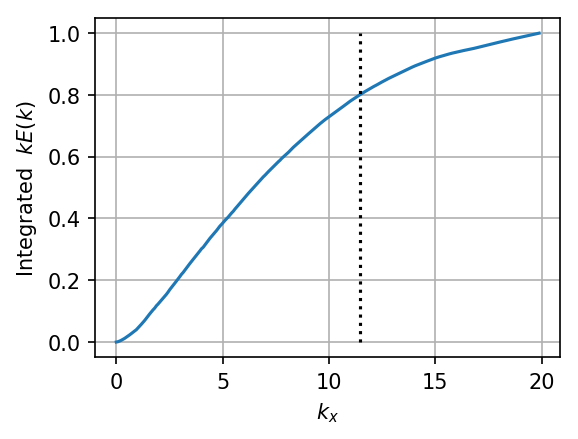

In [40]:
k=np.fromfile('/home/kmatsuno/kc',sep=' ',count=-1)
cumulative=np.fromfile('/home/kmatsuno/cumulative',sep=' ',count=-1)
plt.figure(figsize=(4,3),dpi=150)
plt.plot(k[:-2],cumulative)
plt.plot([11.46,11.46],[0,1],'k:')
plt.grid(True)
plt.xlabel(r'$k_x$')
plt.ylabel(r'Integrated  $kE(k)$')

In [177]:
s = '1'

if s=='1': Mc_list = ['02','04','08','12','16','20']
else: Mc_list = ['02','08','20']
    
fig = plt.figure(figsize=(5,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    
    flist = glob.glob(directory+"xz_pstrain*")
    flist.sort()
    #mat = get_corrcoef(flist,'p','ps11')
    #print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[:,0]),np.std(mat[:,0])))

    qname = 'p'
    qrms,qstd = get_rms(flist[:],qname);#print('{}: [{},{}],'.format(inp.Mc,qrms,qstd))
    #qfrms,qfstd = get_rms(flist,qname+'f');print('{}: [{}],'.format(inp.Mc,qfrms/qrms))
    
    # Let dtheta


0.2: [-0.0469400063632,0.00477926382118],
0.4: [-0.157801407648,0.0185434618807],
0.8: [-0.479226595376,0.0780477125322],
1.2: [-0.620142497286,0.0475373984331],
1.6: [-0.751180448202,0.167521571597],
2.0: [-1.0105720314,0.249941228351],


<Figure size 750x450 with 0 Axes>

In [152]:
pkurt = [3.31,
2.47,
4.46,
4.60,
4.07,
4.24]
pskew=[
-0.23,
-0.14,
-0.16,
0.20,
0.27,
0.26 ,  
]
pmin = [
-0.05+1,
-0.16+0.99,
-0.48+0.97,
-0.62+0.98,
-0.75+0.95,
-0.83+0.95,
]
Mc = ['A','B','C','D','E','F']
for i in range(len(Mc)):
    print('{}1 & {} & {} & {} \\\\'.format(Mc[i],pmin[i],pskew[i],pkurt[i]))

A1 & 0.95 & -0.23 & 3.31 \\
B1 & 0.83 & -0.14 & 2.47 \\
C1 & 0.49 & -0.16 & 4.46 \\
D1 & 0.36 & 0.2 & 4.6 \\
E1 & 0.2 & 0.27 & 4.07 \\
F1 & 0.12 & 0.26 & 4.24 \\


Text(0.5,0,'$M_c$')

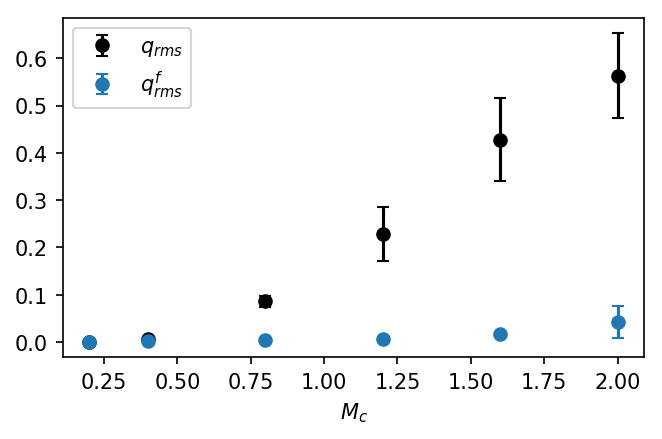

In [127]:
# RMS of filtered quantities
prms = {
0.2: [6.18041431773e-05,2.03602236897e-06],
0.4: [0.00115722750204,0.00016806767428],
0.8: [0.00336847897571,0.000295009599824],
1.2: [0.00957155290431,0.000575108061106],
1.6: [0.0192115516802,0.00248884455654],
2.0: [0.0272009899954,0.00281595079873],
}
prms_f = {
0.2: [1.56708470521e-05,5.57697638615e-07],
0.4: [0.00114454057075,0.000170747342229],
0.8: [0.000828993792531,0.000102503063189],
1.2: [0.00223990346049,0.000119638398186],
1.6: [0.00467763918435,0.000581846407881],
2.0: [0.0122575990786,0.00965627692235]
}
s11rms = {
0.2: [0.00149118671999,7.50999986468e-05],
0.4: [0.00712727951748,0.000391890062733],
0.8: [0.109636597738,0.0141774210309],
1.2: [0.287019725382,0.0657146502505],
1.6: [0.542887620134,0.106566413849],
2.0: [0.714060222817,0.111736744616],
}
s11rms_f = {
0.2: [0.000140806083031,5.15923377737e-06],
0.4: [0.00169354869841,7.39727794336e-05],
0.8: [0.00429894417084,0.000281976840313],
1.2: [0.00851125264501,0.00100363215035],
1.6: [0.0208915889562,0.00262090774025],
2.0: [0.0548492974417,0.0466535373159],
}
s12rms = {
0.2: [0.00123132110535,6.61148166868e-05],
0.4: [0.00561906197864,0.00043192469306],
0.8: [0.0861760411966,0.0121489329934],
1.2: [0.2282659616,0.0574500439039],
1.6: [0.427596055145,0.088093806768],
2.0: [0.563275038348,0.089698607095],
}
s12rms_f = {
0.2: [0.00011742333715,7.26443269656e-06],
0.4: [0.00127635676553,0.000115681387664],
0.8: [0.00354454298241,0.000301476613631],
1.2: [0.00694113984495,0.0011813899106],
1.6: [0.0166963831652,0.0030059596713],
2.0: [0.0425581193668,0.0346095009353],
}
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(5,3),dpi=150)
plotter(s12rms,'ko','$q_{rms}$')
plotter(s12rms_f,'o','$q_{rms}^f$')
plt.legend()
plt.xlabel(r'$M_c$')

In [96]:
prms = {
0.2: [6.18041431773e-05,2.03602236897e-06],
0.4: [0.00115722750204,0.00016806767428],
0.8: [0.00336847897571,0.000295009599824],
1.2: [0.00957155290431,0.000575108061106],
1.6: [0.0192115516802,0.00248884455654],
2.0: [0.0272009899954,0.00281595079873],
}
for key in [0.2,0.4,0.8,]:
    print('%0.2f'%prms[key][0])

AttributeError: 'list' object has no attribute 'sorted'

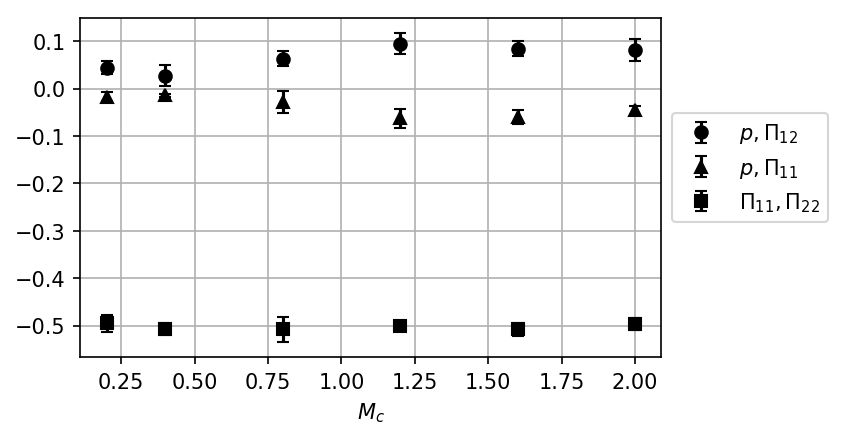

In [96]:
# Using Nx/4=256 modes
p_p12 = {
0.2: [0.043431302009,0.0138319646041],
0.4: [0.0271488785513,0.0216380762091],
0.8: [0.0626504514744,0.015500340806],
1.2: [0.094333787693,0.0223695712819],
1.6: [0.083844161235,0.0161596706967],
2.0: [0.0811799192354,0.0232870249654],  
}
p_p11 = {
0.2: [-0.0169026413827,0.00973708296451],
0.4: [-0.0142323991284,0.00358763435164],
0.8: [-0.0284223882993,0.0236162193755],
1.2: [-0.0628207816337,0.0202951916075],
1.6: [-0.059455116327,0.0151162941769],
2.0: [-0.0460515264015,0.00960653434413], 
}
p11_p22 = {
0.2: [-0.494989868652,0.0181432249203],
0.4: [-0.506581578152,0.0124921369329],
0.8: [-0.507933262701,0.0266752586671],
1.2: [-0.50161313129,0.00538342192377],
1.6: [-0.508085968458,0.0129514385381],
2.0: [-0.496238938694,0.0119915612035], 
}

def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(5,3),dpi=150)
plotter(p_p12,'ko','$p,\Pi_{12}$')
plotter(p_p11,'k^','$p,\Pi_{11}$')
plotter(p11_p22,'ks','$\Pi_{11},\Pi_{22}$')


plt.xlabel('$M_c$')
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 0.75))

In [85]:
def plot_pdf(flist):
    datos = np.zeros([Nx,Nz,len(flist)])

    print('Reading and normalizing data')
    for i,f in enumerate(flist):
        hf = h5py.File(f, 'r')
        dat = np.array(hf['p'])
        datos[:,:,i] = dat/np.std(dat.flatten())
        hf.close()
    datos = datos.flatten()

    # best fit of data
    print('Fitting data')
    (mu, sigma) = norm.fit(datos)
    print(mu,sigma)
    
    # the histogram of the data
    print('Getting histogram')
    plt.figure(figsize=(4,3),dpi=150)
    n, bins, patches = plt.hist(datos, bins=50,alpha=0.5,density=False)

    # add a 'best fit' line
    print('Adding best fit line')
    y = mlab.normpdf( bins, mu, sigma)
    l = plt.plot(bins, y, 'k--', linewidth=2)
    plt.xlabel(r"$p$")
    plt.ylabel('Probability')
    plt.xlim([-10*sigma,10*sigma])
    plt.grid(True)
    plt.show()
    
    # save for later
    savename = dir_out+'/PDF_p'
    np.savez(savename, bins=bins, pdf=y)
    print(savename)

    
# savename = directory+'/img/PDF_p.png'
# plt.savefig(savename,dpi=200,bbox_inches='tight')
# print(savename)
dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/' + dir_out + '/'
flist = glob.glob(dir_out+"xz_pstrain*")
print(flist)
plot_pdf(flist[0])


[]


IndexError: list index out of range

Reading and normalizing data
Fitting data
Getting histogram
Adding best fit line


/gpfs/mira-home/kmatsuno/floatpy_env/lib/python2.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


ValueError: Axis limits cannot be NaN or Inf

<Figure size 600x450 with 0 Axes>

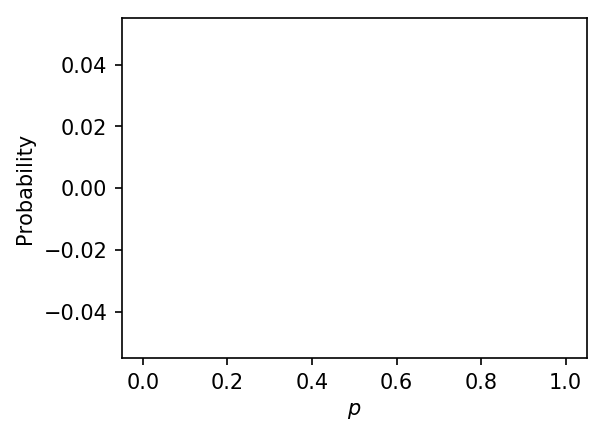

In [74]:
s='1'
Mc_list = ['02','04','08','12','16','20']

fig = plt.figure(figsize=(4,3),dpi=150)

for Mc in Mc_list:
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'

    flist = glob.glob(dir_out+"xz_pstrain*")
    flist.sort()
    plot_pdf(flist)
    
#     flist = glob.glob(dir_out+"*PDF_p*")
#     dat = np.load(flist[0])
#     pdf = dat['pdf']
#     plt.plot(dat['bins'],pdf,label='Mc = {}'.format(inp.Mc))
    
plt.legend()
plt.xlabel('$p^\prime/p_0$')
plt.ylabel('Distribution')
# plt.xlim([-0.4,0.4])
